In [1]:
import numpy as np
from netCDF4 import Dataset
import os
import datetime
import xarray as xr
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import pyart
import cartopy.crs as ccrs
import matplotlib.ticker as mticker


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
/Users/scollis/miniconda3/envs/crocus/lib/python3.11/site-packages/pyart/io/nexrad_level3.py:72: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from xdrlib import Unpacker


In [94]:

'''
Import of StreamLine .hpl (txt) files and save locally in directory. Therefore
the data is converted into matrices with dimension "number of range gates" x "time stamp/rays".
In newer versions of the StreamLine software, the spectral width can be 
stored as additional parameter in the .hpl files.
'''

def convert_to_preferred_format(secs):
   secs = secs % (24 * 3600)
   hour = secs // 3600
   secs %= 3600
   mins = secs // 60
   secs %= 60
   #print("seconds value in hours:",hour)
   #print("seconds value in minutes:",mins)
   return "%02d:%02d:%02d" %(hour, mins, secs)


def hpl2dict(file_path, instrument_name = None, metadata = None):
    #import hpl files into intercal storage
    with open(file_path, 'r') as text_file:
        lines=text_file.readlines()

    #write lines into Dictionary
    data_temp=dict()

    header_n=17 #length of header
    
    if instrument_name is not None:
        data_temp['instrument_name'] = instrument_name
    else:
        data_temp['LIDAR'] = instrument_name
    
    if metadata is not None:
        data_temp['metadata'] = metadata
            
    
    data_temp['filename']=lines[0].split()[-1]
    data_temp['system_id']=int(lines[1].split()[-1])
    data_temp['number_of_gates']=int(lines[2].split()[-1])
    data_temp['range_gate_length_m']=float(lines[3].split()[-1])
    data_temp['gate_length_pts']=int(lines[4].split()[-1])
    data_temp['pulses_per_ray']=int(lines[5].split()[-1])
    data_temp['number_of_waypoints_in_file']=int(lines[6].split()[-1])
    rays_n=(len(lines)-header_n)/(data_temp['number_of_gates']+1)
    
    '''
    number of lines does not match expected format if the number of range gates 
    was changed in the measuring period of the data file (especially possible for stare data)
    '''
    if not rays_n.is_integer():
        print('Number of lines does not match expected format')
        return np.nan
    
    data_temp['no_of_rays_in_file']=int(rays_n)
    data_temp['scan_type']=' '.join(lines[7].split()[2:])
    data_temp['focus_range']=lines[8].split()[-1]
    data_temp['start_time']=pd.to_datetime(' '.join(lines[9].split()[-2:]))
    data_temp['resolution']=('%s %s' % (lines[10].split()[-1],'m s-1'))
    data_temp['range_gates']=np.arange(0,data_temp['number_of_gates'])
    data_temp['center_of_gates']=(data_temp['range_gates']+0.5)*data_temp['range_gate_length_m']

    #dimensions of data set
    gates_n=data_temp['number_of_gates']
    rays_n=data_temp['no_of_rays_in_file']

    # item of measurement variables are predefined as symetric numpy arrays filled with NaN values
    data_temp['radial_velocity'] = np.full([gates_n,rays_n],np.nan) #m s-1
    data_temp['intensity'] = np.full([gates_n,rays_n],np.nan) #SNR+1
    data_temp['beta'] = np.full([gates_n,rays_n],np.nan) #m-1 sr-1
    data_temp['spectral_width'] = np.full([gates_n,rays_n],np.nan)
    data_temp['elevation'] = np.full(rays_n,np.nan) #degrees
    data_temp['azimuth'] = np.full(rays_n,np.nan) #degrees
    data_temp['decimal_time'] = np.full(rays_n,np.nan) #hours
    data_temp['pitch'] = np.full(rays_n,np.nan) #degrees
    data_temp['roll'] = np.full(rays_n,np.nan) #degrees
    
    for ri in range(0,rays_n): #loop rays
        lines_temp = lines[header_n+(ri*gates_n)+ri+1:header_n+(ri*gates_n)+gates_n+ri+1]
        header_temp = np.asarray(lines[header_n+(ri*gates_n)+ri].split(),dtype=float)
        data_temp['decimal_time'][ri] = header_temp[0]
        data_temp['azimuth'][ri] = header_temp[1]
        data_temp['elevation'][ri] = header_temp[2]
        data_temp['pitch'][ri] = header_temp[3]
        data_temp['roll'][ri] = header_temp[4]
        for gi in range(0,gates_n): #loop range gates
            line_temp=np.asarray(lines_temp[gi].split(),dtype=float)
            data_temp['radial_velocity'][gi,ri] = line_temp[1]
            data_temp['intensity'][gi,ri] = line_temp[2]
            data_temp['beta'][gi,ri] = line_temp[3]
            if line_temp.size>4:
                data_temp['spectral_width'][gi,ri] = line_temp[4]

    return data_temp

def read_as_netcdf(file, instrument_name = None, metadata = None):
    field_dict = hpl2dict(file, instrument_name = instrument_name, metadata = metadata)
    initial_time = pd.to_datetime(field_dict['start_time'])

    time = pd.to_datetime([initial_time.strftime('%Y-%m-%d ') \
                           + convert_to_preferred_format(x*60.*60.) for x in field_dict['decimal_time']])

    ds = xr.Dataset(coords={'range':field_dict['center_of_gates'],
                            'time':time},
                    data_vars={'radial_velocity':(['range', 'time'],
                                                  field_dict['radial_velocity']),
                               'beta': (('range', 'time'), 
                                        field_dict['beta']),
                               'intensity': (('range', 'time'),
                                             field_dict['intensity']),
                                'elevation': (('time'),
                                             field_dict['elevation']),
                                'azimuth': (('time'),
                                             field_dict['azimuth'])
                              }
                   )
    
    ds.attrs['instrument_name'] = field_dict['instrument_name']
    if 'metadata' in field_dict.keys():
        for key in field_dict['metadata'].keys():
            ds.attrs[key] = field_dict['metadata'][key]
    
    return ds

def ds2radar_rhi(ds):
    ntilts = len(ds.elevation)
    ngates = len(ds.range)
    myradar = pyart.testing.make_empty_rhi_radar(ngates, ntilts, 1)
    #myradar.sweep_mode = {'data' : ['rhi']}
    myradar.range['data'] = ds.range.values
    myradar.time['data'] = ((ds.time.values - ds.time.values[0])/1e9).astype('f')
    myradar.time['units'] = pd.to_datetime(ds.time.values[0]).strftime("seconds since %Y-%m-%dT%H:%M:%SZ")
    myradar.elevation['data'] = ds.elevation.values
    fld = {'data' : ds.intensity.values.transpose()- 1.0 , 'units' : 'SNR'}
    myradar.add_field('intensity', fld)
    fld = {'data' : ds.radial_velocity.values.transpose() , 'units' : 'm/s'}
    myradar.add_field('velocity', fld)
    
    myradar.metadata['instrument_name'] = ds.attrs['instrument_name']
    attrs = ds.attrs
    for akey in attrs.keys():
        myradar.metadata[akey] = attrs[akey]

    
    return myradar

def ingest_dl_rhi(filen, instrument_name = None, metadata = None):
    return ds2radar_rhi(read_as_netcdf(filen,  instrument_name=instrument_name, metadata=metadata))
    

In [95]:
metad = {'project' : 'Community Research On Climate and Urban Science', "author" : "CROCUS Measurement Strategy Team",
        "contact" : "Scott Collis, scollis@anl.gov, Paytsar Muradyan, pmuradyan@anl.gov", 'assettag': 'CMS-SDL-001'}

dl_obj = ingest_dl_rhi('/Users/scollis/DL/firstexp/Proc/2022/202212/20221214/RHI_240_20221214_012837.hpl',
                      instrument_name = 'ATMOS Doppler LIDAR', metadata=metad)

dl_obj.metadata

{'instrument_name': 'ATMOS Doppler LIDAR',
 'project': 'Community Research On Climate and Urban Science',
 'author': 'CROCUS Measurement Strategy Team',
 'contact': 'Scott Collis, scollis@anl.gov, Paytsar Muradyan, pmuradyan@anl.gov',
 'assettag': 'CMS-SDL-001'}

In [96]:
xl = [-4,4]
yl = [0,3]

(-4.0, 4.0)

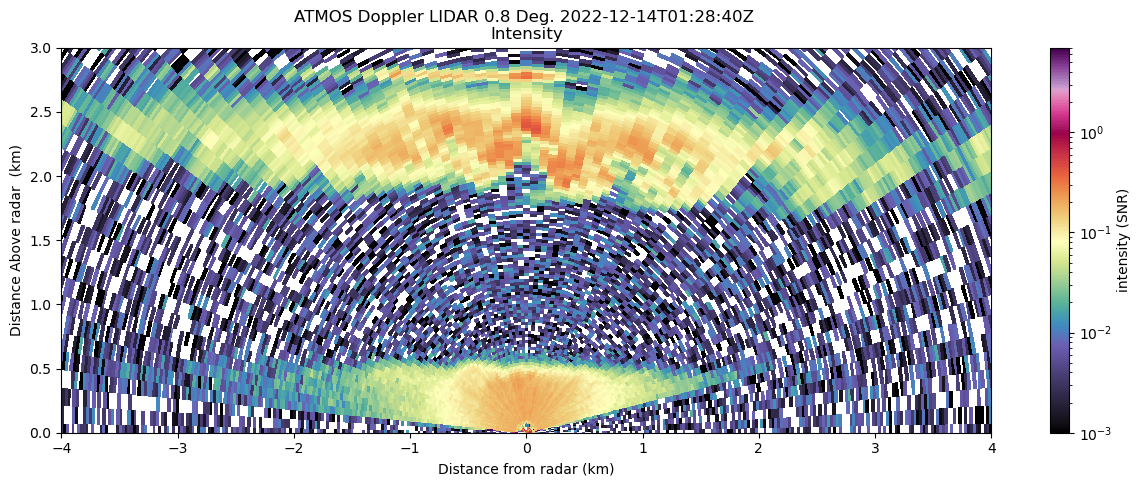

In [97]:
myf = plt.figure(figsize=[15,5])
myd = pyart.graph.RadarDisplay(dl_obj)
myd.plot_rhi('intensity', norm=LogNorm(vmax=7, vmin=0.001), cmap=pyart.graph.cm_colorblind.ChaseSpectral)
plt.ylim(yl)
plt.xlim(xl)

(-4.0, 4.0)

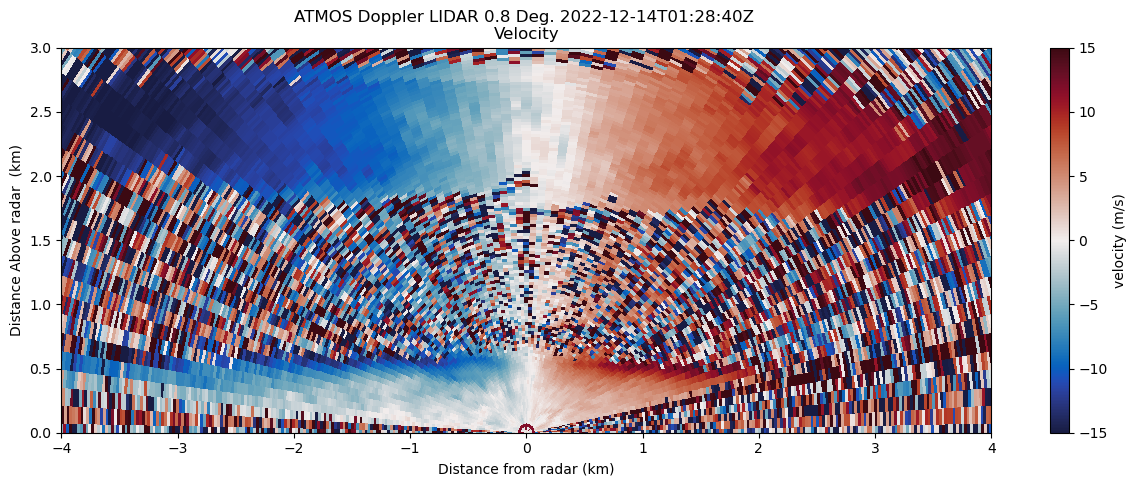

In [64]:
myf = plt.figure(figsize=[15,5])
myd = pyart.graph.RadarDisplay(dl_obj)
myd.plot_rhi('velocity', vmin=-15, vmax=15, cmap=pyart.graph.cm_colorblind.balance)
plt.ylim(yl)
plt.xlim(xl)

In [98]:
pyart.io.write_cfradial('/Users/scollis/DL/test_cfr.nc',dl_obj)

In [99]:
working_test = pyart.io.read('/Users/scollis/DL/test_cfr.nc')

/Users/scollis/miniconda3/envs/crocus/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


(-4.0, 4.0)

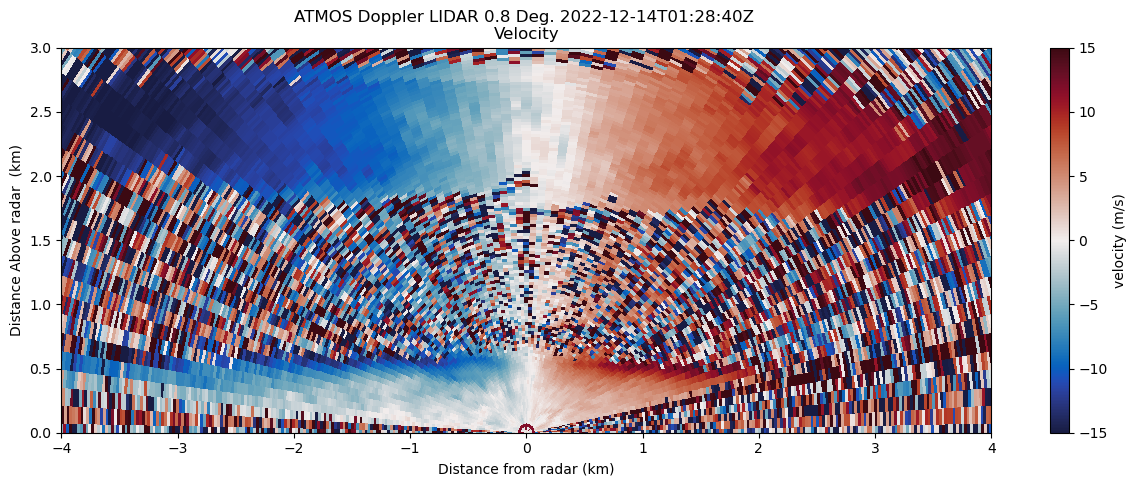

In [100]:
myf = plt.figure(figsize=[15,5])
myd = pyart.graph.RadarDisplay(working_test)
myd.plot_rhi('velocity', vmin=-15, vmax=15, cmap=pyart.graph.cm_colorblind.balance)
plt.ylim(yl)
plt.xlim(xl)